In [1]:
# Adapted from: https://github.com/crispitagorico/Hall-areas/blob/master/Sig-inversion%20through%20Legendre%20polynomials.ipynb
import numpy as np
from main_funcs import Jacobi, Legendre, Chebyshev, Hermite, Fourier
from free_lie_algebra import * 
import matplotlib.pyplot as plt
from tqdm import tqdm

e:\File_VSCode\M3R\m3r_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original point:  0.9692332344763441
Hermite estimate:  0.9692332312918112
Jacobi estimate:  0.968281113632259


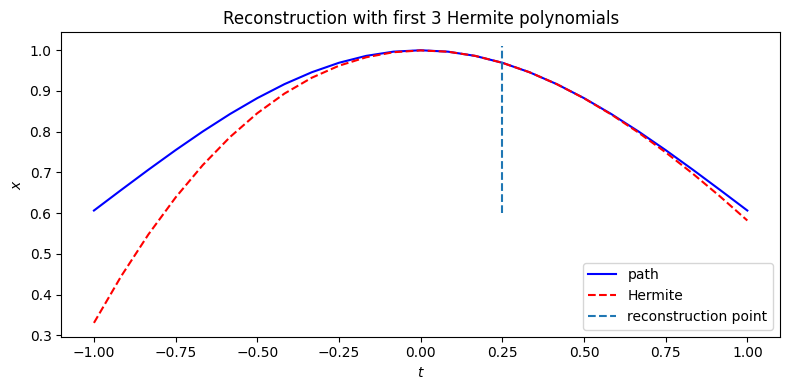

In [2]:
length = 25
t_grid = np.linspace(-1, 1, length)
t0 = 0.25
eps = 0.01

def x_(t):
    return np.exp(-t**2/2)
# def x(t):
#     return x_(t) - x_(-1)

N = 3

hpoly = Hermite(t0, eps)
path_hpoly = hpoly.ploy2path(x_, N, t0)
jpoly = Jacobi(1, 1)
path_jpoly = jpoly.ploy2path(x_, N, t0)
print('Original point: ', x_(t0))
print('Hermite estimate: ', path_hpoly)
print('Jacobi estimate: ', path_jpoly)

plt.figure(figsize=(8, 4), dpi=100)
# for n in range(N):
#     plt.plot(t_grid, hpoly.P(n)(t_grid), alpha=0.3)
plt.plot(t_grid, x_(t_grid), label='path', c='blue')
plt.plot(t_grid, hpoly.ploy2path(x_, N, t_grid), label='Hermite', c='red', linestyle='--')
plt.vlines(t0, min(x_(t_grid))*0.99, max(x_(t_grid))*1.01, linestyles='dashed', label='reconstruction point')
plt.legend()
plt.title(f'Reconstruction with first {N} Hermite polynomials')
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.tight_layout()

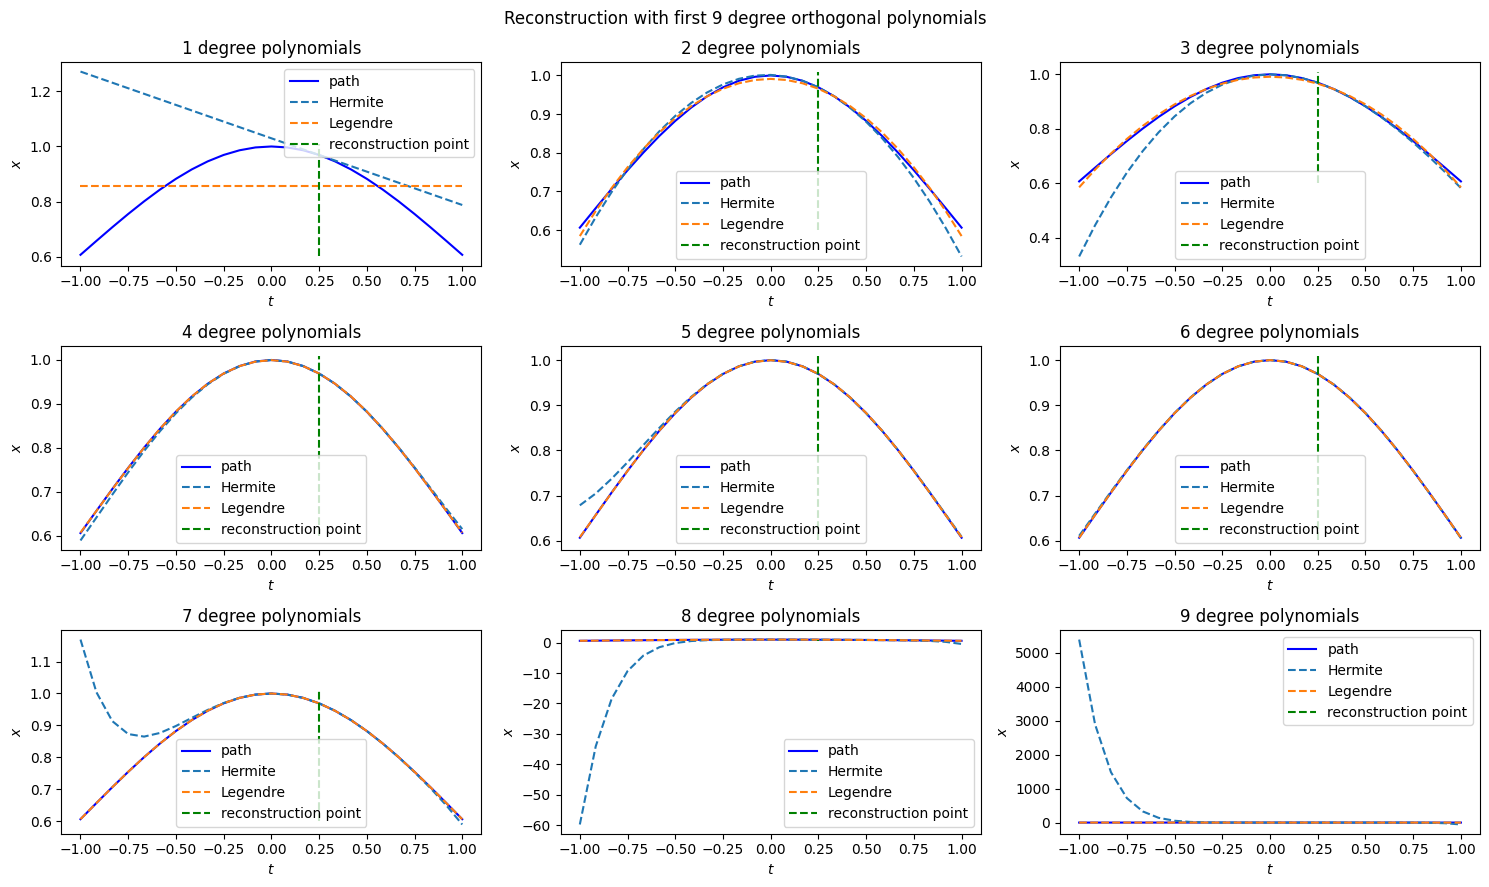

In [3]:
# visualisation of Hermite compared with legendre
plt.figure(figsize=(15, 9), dpi=100)
for n in range(1, 10):
    plt.subplot(3, 3, n)
    hpoly = Hermite(t0, eps)
    jpoly = Legendre()

    plt.plot(t_grid, x_(t_grid), label='path', c='blue')
    plt.plot(t_grid, hpoly.ploy2path(x_, n, t_grid), label='Hermite', linestyle='--')
    plt.plot(t_grid, jpoly.ploy2path(x_, n, t_grid), label='Legendre', linestyle='--')
    plt.vlines(t0, min(x_(t_grid))*0.99, max(x_(t_grid))*1.01, linestyles='dashed', colors='g', label='reconstruction point')
    plt.title(f'{n} degree polynomials')
    plt.legend()
    plt.xlabel(r'$t$')
    plt.ylabel(r'$x$')
plt.suptitle(f'Reconstruction with first 9 degree orthogonal polynomials')
plt.tight_layout()

In [4]:
# construct a random function
def random_sine_generator(seed=1531):
    np.random.seed(seed)
    freq = np.random.normal(np.random.uniform(5, 10), np.random.uniform(2, 5), size=np.random.randint(2, 10))
    def func(t):
        return sum(np.sin(freq*t))
    return func

100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


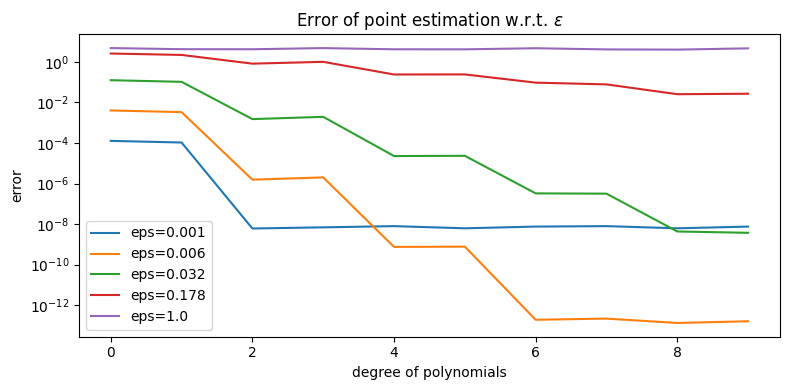

In [5]:
# study the error as a function of N for various values of variance
iter_num = 10
d_range = range(10)
eps_range = 10**np.linspace(-3, 0, 5)
poly_dict = {eps: {'poly': Hermite(t0, eps), 'error': np.zeros(d_range[-1]-d_range[0]+1)} for eps in eps_range}
for n in tqdm(d_range):
    error = 0
    for i in range(iter_num):
        func = random_sine_generator(seed=np.random.randint(10, 100))
        for sub_dict in poly_dict.values():
            sub_dict['error'][n-d_range[0]] += abs(sub_dict['poly'].ploy2path(func, n, t0) - func(t0))

plt.figure(figsize=(8, 4), dpi=100)
for name, sub_dict in poly_dict.items():
    plt.plot(d_range, sub_dict['error']/iter_num, label=f'eps={np.round(name, 3)}')
plt.legend()
plt.yscale('log')
plt.xlabel('degree of polynomials')
plt.ylabel('error')
plt.title(r'Error of point estimation w.r.t. $\epsilon$')
plt.tight_layout()
plt.show()

100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


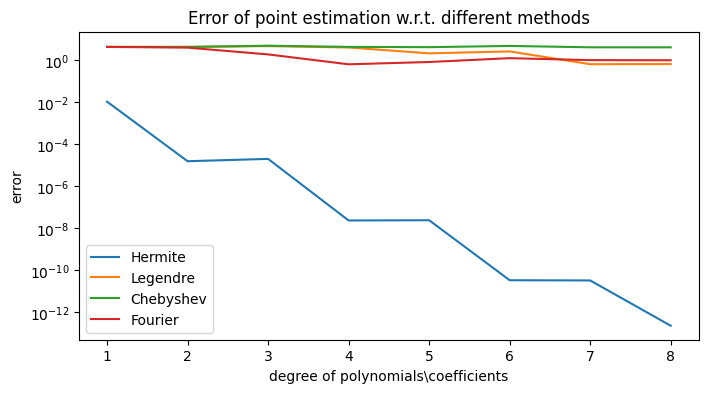

In [6]:
# study error as a function of N for various polynomials
iter_num = 10
d_range = range(1, 9)
poly_dict = {'Hermite': {'poly': Hermite(t0, eps), 'error': np.zeros(d_range[-1]-d_range[0]+1)},
             'Legendre': {'poly': Legendre(), 'error': np.zeros(d_range[-1]-d_range[0]+1)},
             'Chebyshev': {'poly': Chebyshev(), 'error': np.zeros(d_range[-1]-d_range[0]+1)},
             'Fourier': {'poly': Fourier(t_grid), 'error': np.zeros(d_range[-1]-d_range[0]+1)}}
for n in tqdm(d_range):
    error = 0
    for i in range(iter_num):
        func = random_sine_generator(seed=np.random.randint(10, 100))
        for sub_dict in poly_dict.values():
            sub_dict['error'][n-d_range[0]] += abs(sub_dict['poly'].ploy2path(func, n, t0) - func(t0))

plt.figure(figsize=(8, 4), dpi=100)
for name, sub_dict in poly_dict.items():
    plt.plot(d_range, sub_dict['error']/iter_num, label=name)
plt.legend()
plt.yscale('log')
plt.xlabel('degree of polynomials\coefficients')
plt.ylabel('error')
plt.title(r'Error of point estimation w.r.t. different methods')
plt.show()

In [7]:
# verify recurrence relation of signature
length = 200
t_grid = np.linspace(-1, 1, length)

def x_(t):
    return np.cos(15*t) - np.sin(3*t)
def x(t):
    return x_(t) - x_(-1)

N = 15
trunc_sig = N + 2

poly = Jacobi(0.5, 0.5)
path_poly = poly.ploy2path(x, N, t_grid)

path = x(t_grid)
path_time = np.c_[t_grid, path*poly.weight(t_grid)]

sig = signature_of_path_iisignature(path_time, trunc_sig)

path_sig = poly.sig2path(sig, N, t_grid)

e:\File_VSCode\M3R\M3R_LMU\main_funcs.py:116: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  an = quad(lambda t: x(t)*P_n(t)*self.weight(t), self.x1, self.x2)[0]/snorm_n
e:\File_VSCode\M3R\M3R_LMU\main_funcs.py:145: RuntimeWarning: divide by zero encountered in divide
  return sig_map(t_grid) / self.weight(t_grid)


In [8]:
for n in range(N):
    print((poly.a_sig(sig, n)-poly.a(x, n))**2)

2.3815498678581882e-09
2.1143916168640336e-08
9.168638499353928e-08
2.485875469343975e-08
6.692503483024273e-07
2.1939451885005014e-07
3.291756693694893e-06
4.970909533292253e-07
9.474075795916072e-06
9.02890712851477e-07
5.557066026248266e-06
1.3862083523713585e-06
9.252839924685261e-07
1.8946227609542305e-06
2.2434080441331228e-05


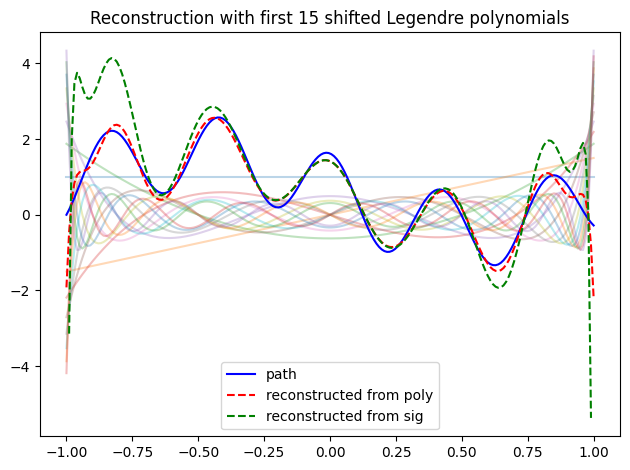

In [9]:
for n in range(N):
    plt.plot(t_grid, poly.P(n)(t_grid), alpha=0.3)
plt.plot(t_grid, path, label='path', c='blue')
plt.plot(t_grid, path_poly, label='reconstructed from poly', c='red', linestyle='--')
plt.plot(t_grid, path_sig, label='reconstructed from sig', c='g', linestyle='--')
plt.legend()
plt.title(f'Reconstruction with first {N} shifted Legendre polynomials')
plt.tight_layout()

In [10]:
# try recurrence relation of signature for high frequency sigals
def x_(t):
    return np.cos(35*t) - np.sin(5*t)
def x(t):
    return x_(t) - x_(-1)

N = 15
trunc_sig = N + 2

poly = Jacobi(0, 0)
path_poly = poly.ploy2path(x, N, t_grid)

path = x(t_grid)
path_time = np.c_[t_grid, path*poly.weight(t_grid)]

sig = signature_of_path_iisignature(path_time, trunc_sig)

path_sig = poly.sig2path(sig, N, t_grid)

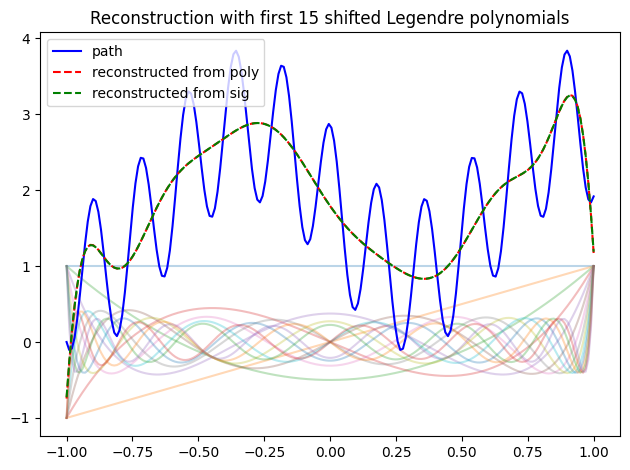

In [11]:
for n in range(N):
    plt.plot(t_grid, poly.P(n)(t_grid), alpha=0.3)
plt.plot(t_grid, path, label='path', c='blue')
plt.plot(t_grid, path_poly, label='reconstructed from poly', c='red', linestyle='--')
plt.plot(t_grid, path_sig, label='reconstructed from sig', c='g', linestyle='--')
plt.legend()
plt.title(f'Reconstruction with first {N} shifted Legendre polynomials')
plt.tight_layout()